In [1]:
from dados_hidroweb import converte_dados
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from graficos import boxplot_mes,prec_mensal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import ceil, log


dados=converte_dados('Dados')
data_construcao=pd.to_datetime(['31/12/1984'])
dados=dados.loc[:data_construcao[0]]
chuvas=dados[['00160000','00259000']]
vazoes=dados[['16100000','16080000']]

## Survival Curves

•  O conceito fundamental na análise de sobrevivência é a curva de sobrevivência;
Sua função mapeia desde a duração, t, até à probabilidade de sobrevivência ser superior a t;
A curva de sobrevivência é o complemento da CDF (distribuição da duração); 
\begin{equation}
    S(t) = 1 - CDF(t)
\end{equation}
- $S(t)$ é Curva de sobrevivência
- $CDF(t)$ é a probabilidade de um tempo de vida inferior ou igual a t.

In [2]:
def curva_permanencia(dados,logscale=True):
    plt.figure(num=None, figsize=(12, 9), dpi=100, facecolor='w', edgecolor='k')
    plt.grid(True,which="both",ls="-")
    ymax=0
    #ax = plt.gca()
    for name in dados.columns:
        dado=dados.loc[dados[name]>10].dropna()
        serie=dado[name]
        serie=serie
        n=len(serie)
        y_1 = np.sort(serie)
        y = y_1[::-1]
        if ymax < y.max():
            ymax=y.max()
        x = (np.arange(1,n+1) / n)*100
        _ = plt.plot(x,y,linestyle='-')
        _ = plt.plot(x,y_1,linestyle='-')
    plt.legend(list(dados.columns)+list(dados.columns), loc='best')
    plt.margins(0.02) 
    if logscale==True:
        ticks = 10**np.arange(1,ceil(log(ymax,10)) + 1,1)
        ticks[-1:]+=1
        plt.yticks(list(ticks))
        plt.yscale('log')
        plt.tick_params(axis='y', which='minor')
        
    _ = plt.xlabel('Probabilidade (%)',fontsize=14)
    _ =  plt.ylabel('Vazão m³/s',fontsize=14)
    plt.xticks(np.arange(0,101,step=10))
    plt.show()

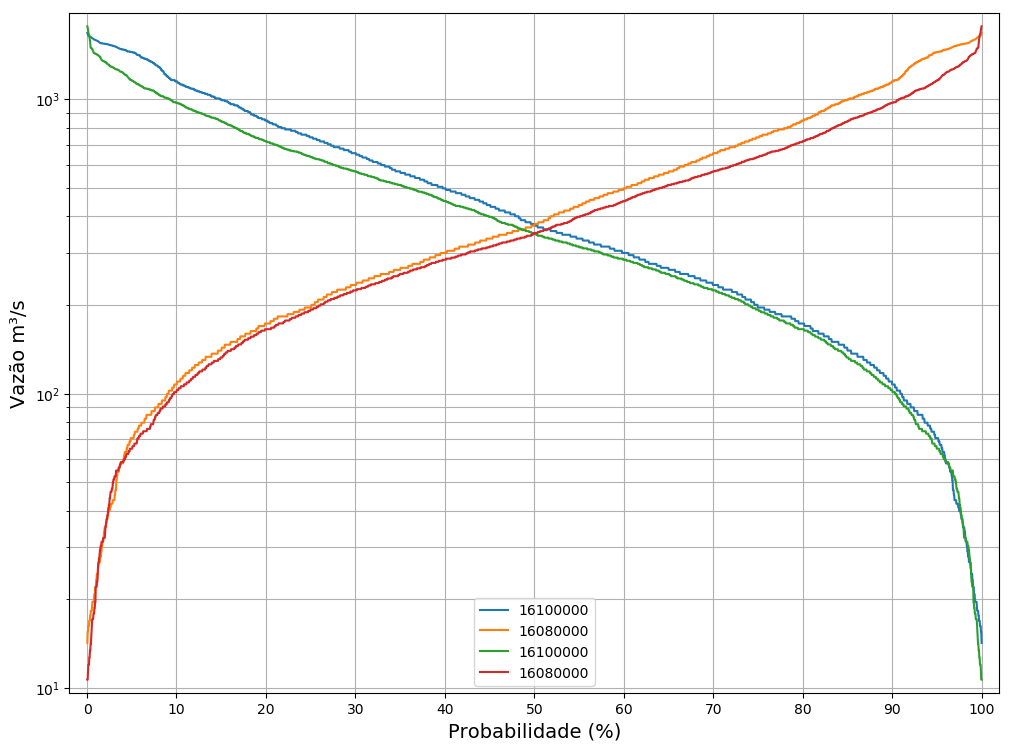

In [3]:
curva_permanencia(vazoes)

In [4]:
from scipy.stats import halfnorm,norm

In [5]:
parameters = norm.fit(vazoes['16100000'].dropna())
print('Parâmetros encontrados: loc={}, scale={}'
      .format(round(parameters[0],2),round(parameters[1],2)))

Parâmetros encontrados: loc=616.92, scale=474.83


In [6]:
parameters_half = halfnorm.fit(vazoes['16100000'].dropna())
print('Parâmetros encontrados: loc={}, scale={}'
      .format(round(parameters_half[0],2),round(parameters_half[1],2)))

Parâmetros encontrados: loc=14.2, scale=765.39


In [7]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    data=data.dropna()
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1,n+1) / n

    return x, y

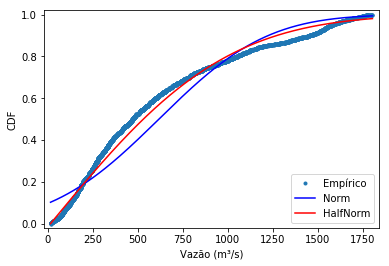

In [8]:
x_1, y_1 = ecdf(vazoes['16100000'])
x_2 = np.linspace(vazoes['16100000'].dropna().min(),vazoes['16100000'].dropna().max(),500)
y_2 = norm.cdf(x_2, parameters[0], parameters[1])
y_3 = halfnorm.cdf(x_2, parameters_half[0], parameters_half[1])
# Generate plot
_ = plt.plot(x_1, y_1, marker='.', linestyle = 'none')
_ = plt.plot(x_2, y_2, marker=' ', linestyle = '-',color='blue')
_ = plt.plot(x_2, y_3, marker=' ', linestyle = '-',color='red')
# Label the axes
plt.legend(('Empírico', 'Norm','HalfNorm'), loc='lower right')
_ = plt.xlabel('Vazão (m³/s)')
_ = plt.ylabel('CDF')

# Display the plot
plt.margins(0.02)
plt.show()

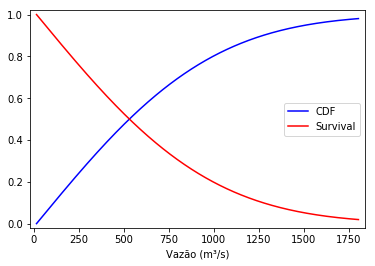

In [9]:
x_1 = np.linspace(vazoes['16100000'].dropna().min(),vazoes['16100000'].dropna().max(),500)
y_1 = halfnorm.cdf(x_1, parameters_half[0], parameters_half[1])
y_2 = halfnorm.sf(x_1, parameters_half[0], parameters_half[1])
# Generate plot
_ = plt.plot(x_1, y_1, marker=' ', linestyle = '-',color='blue')
_ = plt.plot(x_1, y_2, marker=' ', linestyle = '-',color='red')
# Label the axes
plt.legend(('CDF', 'Survival'), loc='best')
_ = plt.xlabel('Vazão (m³/s)')

# Display the plot
plt.margins(0.02)
plt.show()

## Hazard Function

• A partir da curva de sobrevivência, podemos derivar a Hazard Function.

\begin{equation}
    \lambda(t) = \frac{S(t)-S(t+1)}{S(t)}
\end{equation}

\begin{equation}
    PMF(t) = S(t)-S(t+1)
\end{equation}

• Função de perigo modela quais períodos têm as maiores ou menores chances de um evento;

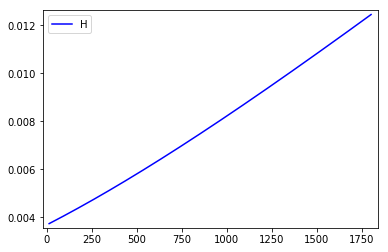

In [10]:
x_1 = np.linspace(vazoes['16100000'].dropna().min(),vazoes['16100000'].dropna().max(),500)
y = halfnorm.sf(x_1, parameters_half[0], parameters_half[1])
hf = (y[:-1]-y[1:])/y[:-1]

# Generate plot
_ = plt.plot(x_1[:-1], hf, marker=' ', linestyle = '-',color='blue')
# Label the axes
plt.legend(('Hazard'), loc='best')

# Display the plot
plt.margins(0.02)
plt.show()

## Estimação de Kaplan-Meier

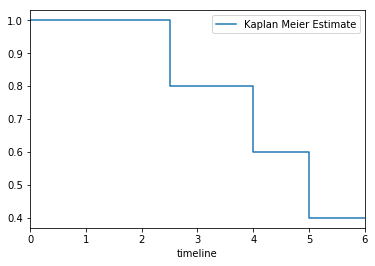

In [17]:
# Python code to create the above Kaplan Meier curve
from lifelines import KaplanMeierFitter

## Example Data 
durations = [5,6,6,2.5,4]
event_observed = [1, 0, 0, 1, 2]

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
_=kmf.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

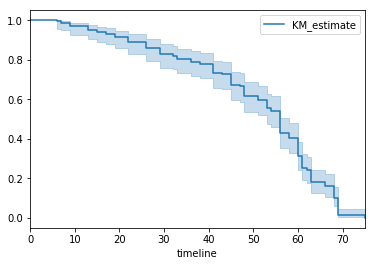

In [23]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons

df = load_waltons()
T = df['T']
E = df['E']

kmf = KaplanMeierFitter(alpha=0.05)
kmf.fit(T, event_observed=E)
_=kmf.plot()